# Null Imputation and Data Pre-processing

In [71]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import modelling as ml
from visualisations import compare_histograms
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor

# set random seed for reproducibility
np.random.seed(42)

sns.set_theme(context='notebook', style='darkgrid', palette='Set3')

In [72]:
df = pd.read_csv('../data/clean_combined_wines.csv')
df.set_index('name', inplace=True)
df.head()

,region,country,vintage,producer,wine_variety,grape_variety,price,rating,rating_qty,abv,reviewed_by,from_vivino
name,,,,,,,,,,,,
00 Wines Vgw Chardonnay 2017,Willamette Valley,United States,2017,00 Wines,white,Chardonnay,65.71,0.0,0,13.0,"JS, WE, WS",False
00 Wines Vgr Pinot Noir 2019,Willamette Valley,United States,2019,00 Wines,red,Pinot Noir,82.14,0.0,0,12.9,"WE, JS, RP",False
00 Wines Egw Chardonnay 2019,Willamette Valley,United States,2019,00 Wines,white,Chardonnay,95.28,0.0,0,NaN,"JS, RP, WE",False
100 Nails Ranch Pinot Noir 2019,Central Coast,United States,2019,100 Nails Ranch,red,Pinot Noir,13.96,0.0,0,14.2,WW,False
100 Nails Ranch Chardonnay 2019,Sonoma County,United States,2019,100 Nails Ranch,white,Chardonnay,13.96,0.0,0,14.2,0,False


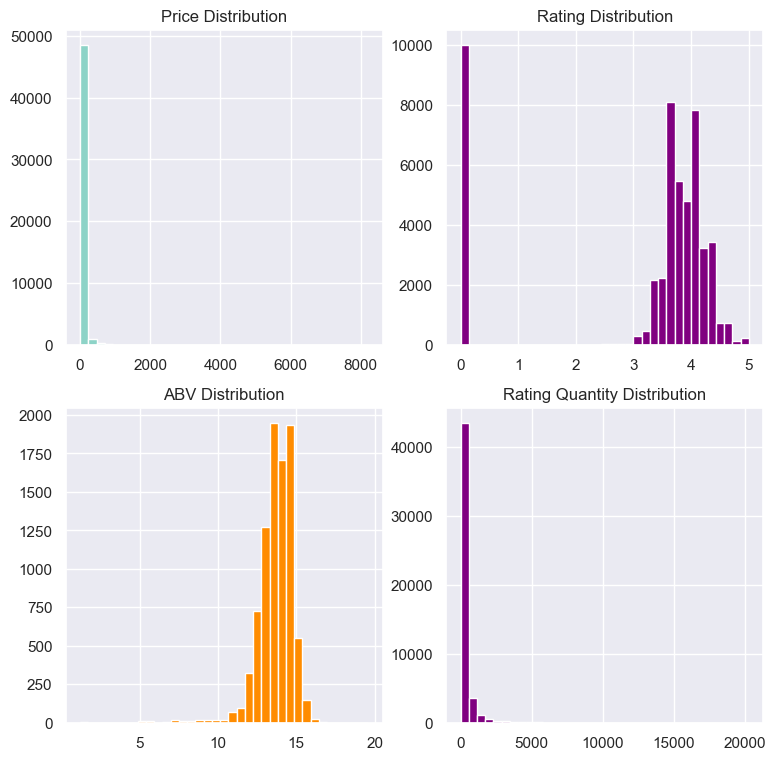

In [73]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))  # 4 subplots

# plot price
axs[0, 0].hist(df['price'], bins=35)
axs[0, 0].set_title('Price Distribution')
axs[0, 0].grid(True)

# plot rating
axs[0,1].hist(df['rating'], bins=35, color='Purple')
axs[0,1].set_title('Rating Distribution')  # Adjusted title and x label
axs[0,1].grid(True)

# plot rating_qty
axs[1, 1].hist(df['rating_qty'], bins=35, color='Purple')
axs[1, 1].set_title('Rating Quantity Distribution')  # Adjusted title and x label
axs[1, 1].grid(True)

# plot abv
axs[1, 0].hist(df['abv'], bins=35, color='DarkOrange')
axs[1, 0].set_title('ABV Distribution')  # Provided a title and x label
axs[1, 0].grid(True)

* Prices are heavily right skewed and would likely benefit from a logarithmic transformation before modelling.
* Rating qty also heavily right skewed and would likely benefit from a logarithmic transformation before modelling. Most wines have very few reviews, with some extreme outliers up to a max of 29389. 
* ABV content fairly normally distibuted with clear spike at median of 13.5% 

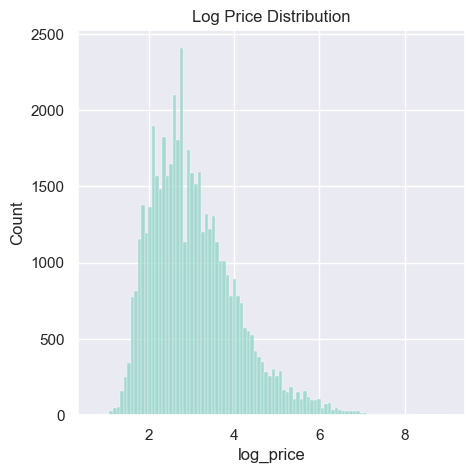

In [74]:
# remove price outliers from dataframe, log transform price and plot

df['log_price'] = np.log(df['price'])
plt.figure(figsize=(5, 5))
plt.title('Log Price Distribution')
sns.histplot(df['log_price'], bins=100)  # kde=False turns off the kernel density estimate plot overlay
plt.show();

* Log price much more normally distributed. 

Max outlier bound log_price: 5.591
Number of remaining rows: 48738, rows removed: 1158


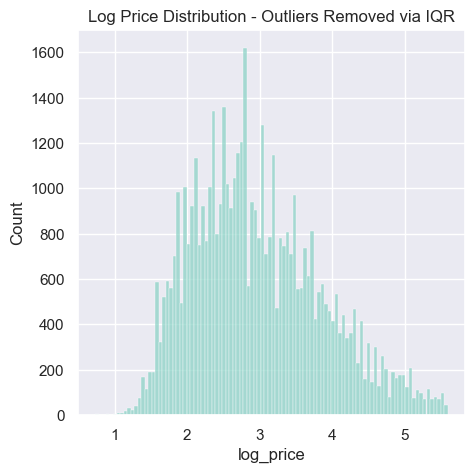

In [75]:
# calculate interquartile range of price, and set a limit at 1.5 IQR above 75% percentile
Qrt1 = np.quantile(df['log_price'], 0.25)
Qrt3 = np.quantile(df['log_price'], 0.75)
price_IQR = Qrt3 - Qrt1
outlier_price_limit = Qrt3 + (price_IQR * 1.5)
df_IQR_price = df[df['log_price'] < outlier_price_limit]
print('Max outlier bound log_price: ', round(outlier_price_limit,3), sep='')
print(f'Number of remaining rows: {df_IQR_price.shape[0]}, rows removed: {df.shape[0] - df_IQR_price.shape[0]}')
plt.figure(figsize=(5, 5))
plt.title('Log Price Distribution - Outliers Removed via IQR')
sns.histplot(df_IQR_price['log_price'], bins=100) 
plt.show();

In [76]:
df['log_price'].describe()

count    49896.000000
mean         3.047707
std          1.010554
min          0.732368
25%          2.302585
50%          2.881442
75%          3.617920
max          9.013674
Name: log_price, dtype: float64

* One of the data scrapes in our original data set had a cut off for minimum number of reviews. Hence the sharp drop in log rating_qty at around 3.5.

## Reduce Categories 

In [77]:
print('Prior Length:', df['region'].value_counts().shape[0])
region_value_counts = df['region'].value_counts()
remove_regions = region_value_counts[region_value_counts < 31]
df['region'] = df['region'].apply(lambda x: 'Unknown' if x in remove_regions.index else x)
print('Post Length:', df['region'].value_counts().shape[0])

Prior Length: 886
Post Length: 306


In [78]:
print('Prior Length:', df['country'].value_counts().shape[0])
region_value_counts = df['country'].value_counts()
remove_regions = region_value_counts[region_value_counts < 31]
df['country'] = df['country'].apply(lambda x: 'Unknown' if x in remove_regions.index else x)
print('Post Length:', df['country'].value_counts().shape[0])

Prior Length: 34
Post Length: 23


In [79]:
df['vintage'].value_counts()

vintage
2016    8031
2017    7845
2018    7124
2015    6108
2019    3818
2014    3490
2020    3031
2013    2420
2021    1742
2012    1628
2011    1187
2010     792
2005     662
2009     408
2008     376
2006     216
2007     211
2004     135
2000     109
1999      88
2001      77
2003      72
2002      64
1996      44
1998      44
1997      42
1995      42
2022      14
1992      12
1993      11
1990      11
1994      10
1989      10
1991       8
1988       6
1985       2
1971       1
1978       1
1983       1
1975       1
1984       1
1969       1
Name: count, dtype: int64

In [80]:
df['age'] = df['vintage'].apply(lambda x: 2024 - int(x))

# Zero Values and Null Imputation

### Imputing ABV

In [81]:
df.columns

Index(['region', 'country', 'vintage', 'producer', 'wine_variety',
       'grape_variety', 'price', 'rating', 'rating_qty', 'abv', 'reviewed_by',
       'from_vivino', 'log_price', 'age'],
      dtype='object')

In [82]:
print(f'Ratings zero values: {(df["rating"] == 0).sum()}')
print(f'Ratings_qty zero values: {(df["rating_qty"] == 0).sum()}')
print(f'ABV nulls: {(df["abv"].isna().sum())}')

Ratings zero values: 9998
Ratings_qty zero values: 9998
ABV nulls: 40947


## Iterative Imputer

**With all categories label encoded**

In [83]:
columns_to_encode = ['region', 'country', 'vintage', 'wine_variety', 'grape_variety', 'from_vivino', 'producer']

# Initialize a LabelEncoder
le = LabelEncoder()

# Loop over the columns and apply Label Encoding
for column in columns_to_encode:
    # The LabelEncoder expects a 1D array, so we use df[column]
    df[column] = le.fit_transform(df[column].astype(str))  # Ensure data type is string for encoding


In [84]:
#features_for_imputation = df[['abv']]
it_imp = IterativeImputer(estimator=LinearRegression(), 
                           max_iter=5)
imputed_data = it_imp.fit_transform(df.drop(columns = ['reviewed_by']))
imputed_data = pd.DataFrame(imputed_data, columns=df.drop(columns = ['reviewed_by']).columns)

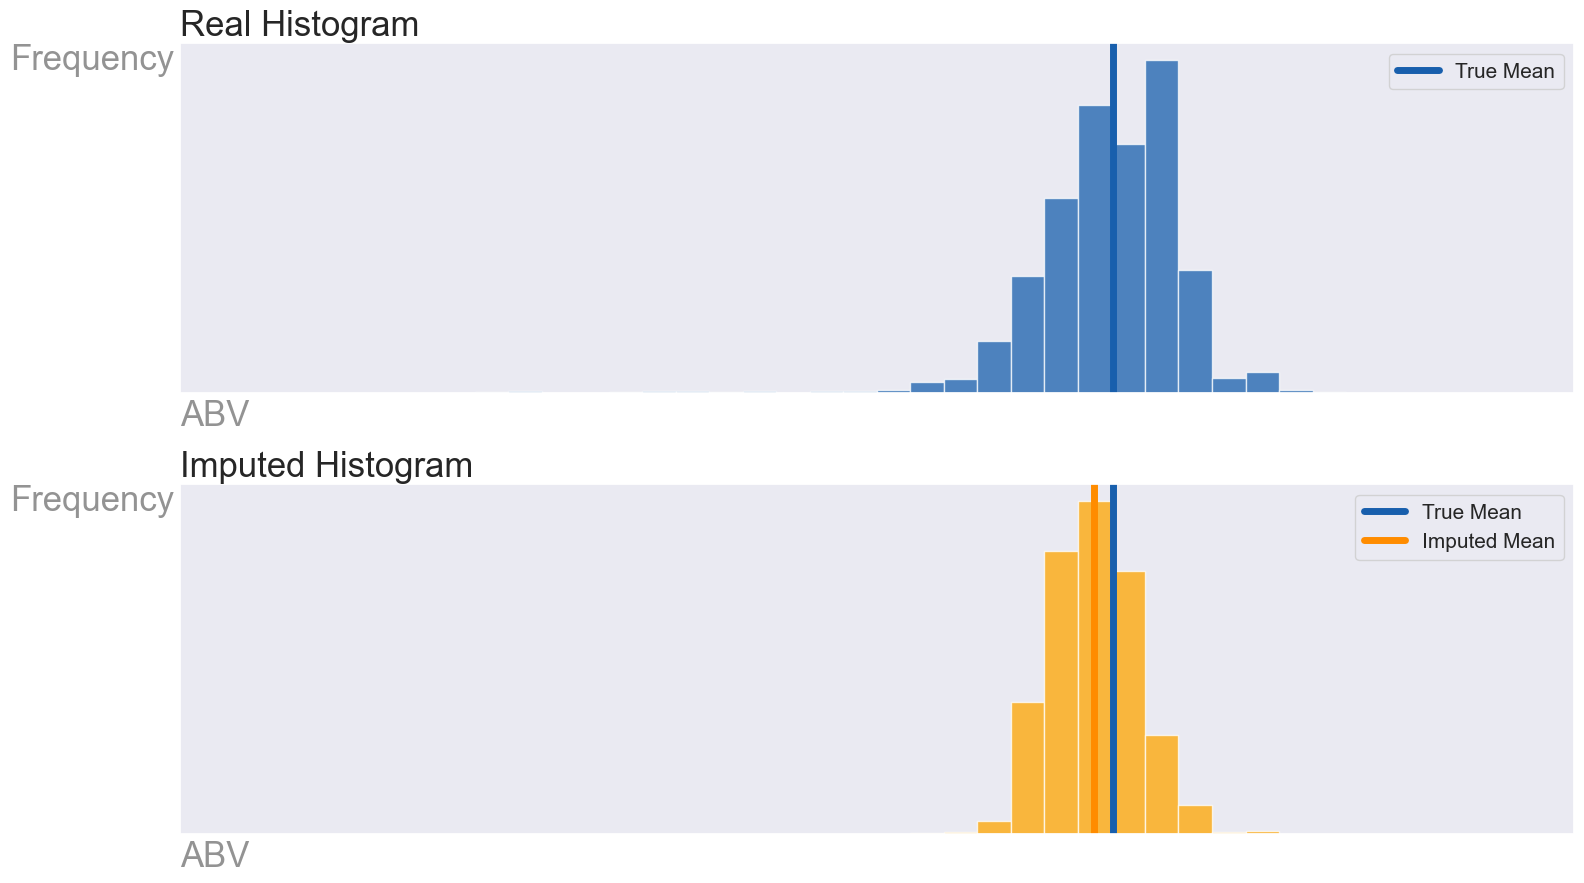

In [85]:
compare_histograms(imputed_column = imputed_data['abv'],
                   original_column = df['abv'],
                   x_label = 'ABV',
                   y_label = 'Frequency', bins = 40)

In [86]:
# Features_for_imputation = df[['abv']]
it_imp_rf = IterativeImputer(estimator=DecisionTreeRegressor(), 
                           max_iter=5)
imputed_data_rf = it_imp_rf.fit_transform(df.drop(columns = ['reviewed_by']))
imputed_data_rf = pd.DataFrame(imputed_data_rf, columns=df.drop(columns = ['reviewed_by']).columns)

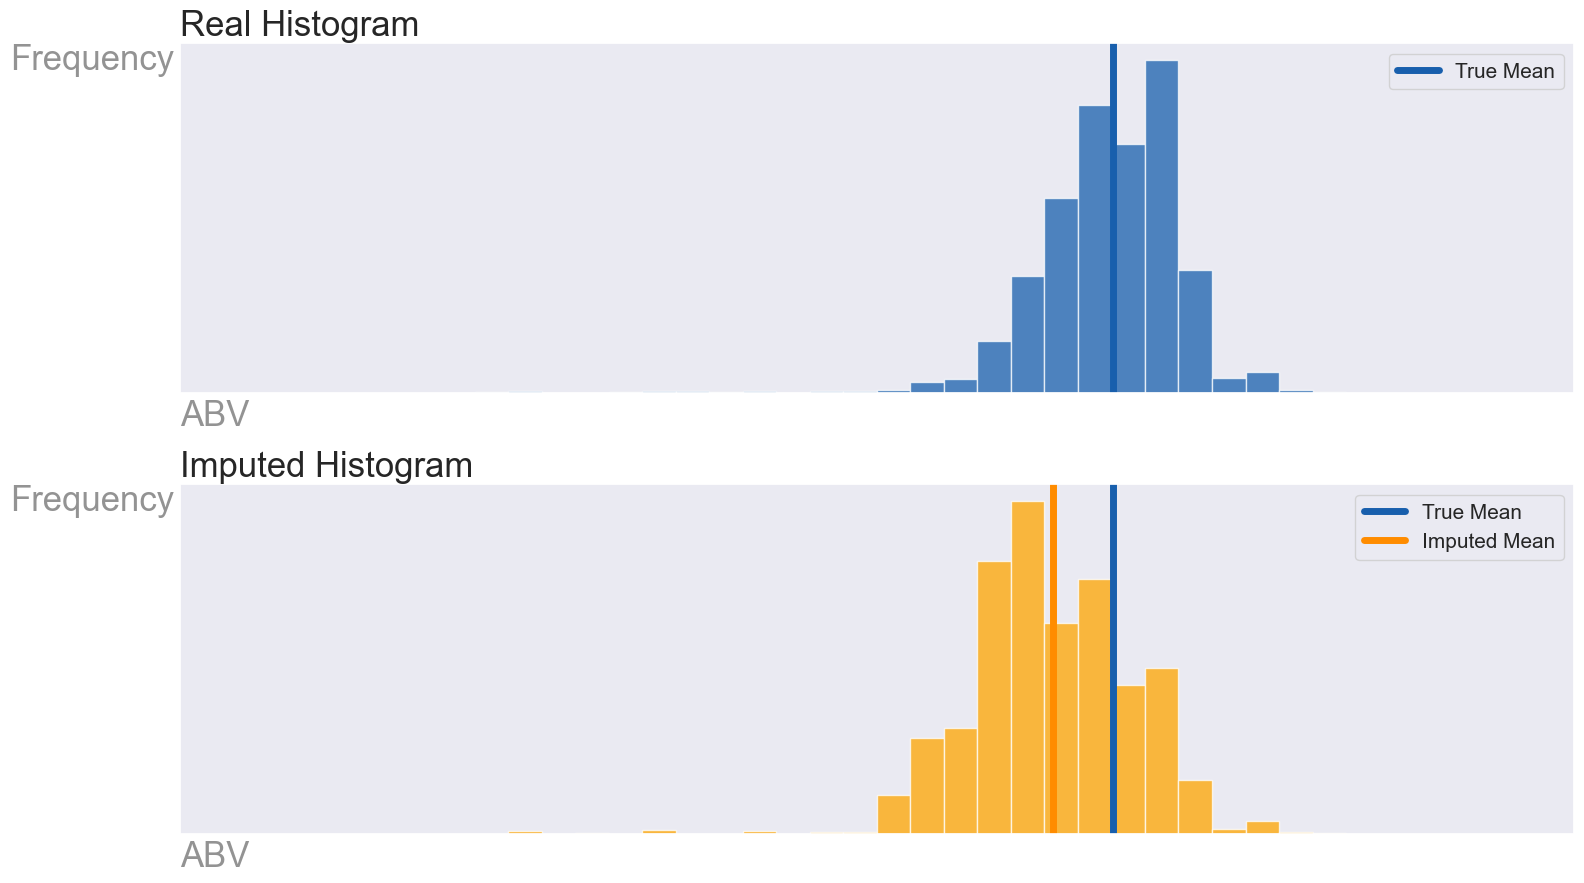

In [87]:
compare_histograms(imputed_column = imputed_data_rf['abv'],
                   original_column = df['abv'],
                   x_label = 'ABV',
                   y_label = 'Frequency', bins = 40)

The linear regression imputation is better at maintaining the mean of the distrbution and although it reduces the spread of the ABV distribution it matches the over all shape with less outliers than decision trees. 

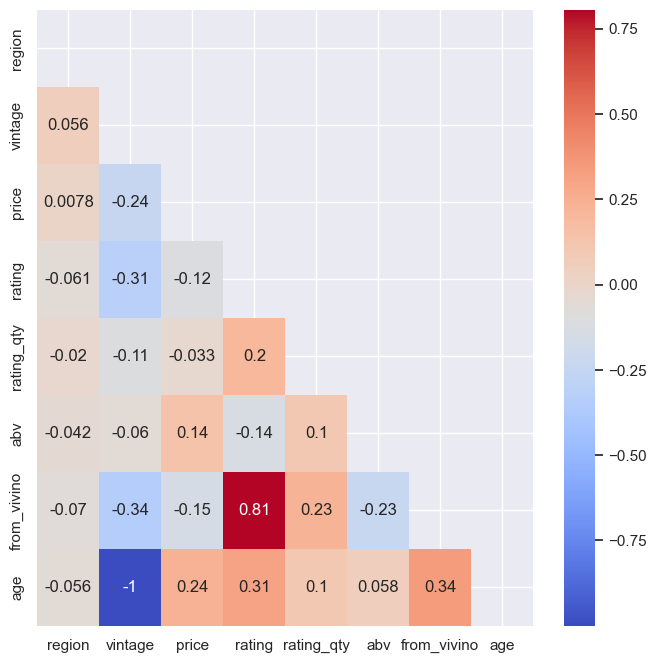

In [88]:
numeric = imputed_data.drop(columns = ['country', 'wine_variety', 'grape_variety', 'producer', 'log_price'])

plt.figure(figsize=(8, 8))

# Set up mask to be "True" in the upper triangle.
mask = np.zeros_like(numeric.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(numeric.corr(), mask = mask, annot=True, cmap='coolwarm');

In [89]:
imputed_data.set_index(df.index, inplace=True)
imputed_data.to_csv('../data/modelling_wines.csv', index=True)